# CLOSED LOOP SYSTEMS

This notebook is a companion to the slides for understanding closed loop systems.

# Preliminaries

In [1]:
!pip install -q control
!pip install -q tellurium
!pip install -q controlSBML

import control
import controlSBML as ctl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import tellurium as te

In [2]:
TIMES = ctl.makeSimulationTimes(0, 5, 500)

# Antimony Model

$\$S_1 \xrightarrow{k_1 S_1} S_2$,
$S_2 \xrightarrow{k_2 S_3} S_3$,
$S_3 \xrightarrow{k_3 S_3} S_2$,
$S_2 \xrightarrow{k_2 S_3} \emptyset$,

In [3]:
# Constants
CONSTANT_DCT = {"k1": 1, "k2": 2, "k3": 3, "k4": 4}
s = sympy.Symbol("s")
REF = 10

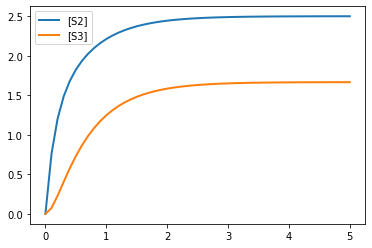

In [4]:
MODEL = """
$S1 -> S2; k1*$S1
J1: S2 -> S3; k2*S2
J2: S3 -> S2; k3*S3
J3: S2 -> ; k4*S2

k1 = 0
k2 = 0
k3 = 0
k4 = 0
$S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
RR = te.loada(MODEL)
for k in CONSTANT_DCT.keys():
    RR[k] = CONSTANT_DCT[k]
RR.simulate()
RR.plot()


<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13-Closed-Loop-Systems/Closed-Loop-Transfer-Function.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

We are going to control ``S3`` by changing ``S2``. That is, $U(s) = S_2  (s)$
and $Y(s) = S_3 (s)$.

# Simulating the Closed Loop System

In [5]:
ctlsb = ctl.ControlSBML(RR,  input_names=["S2"], output_names=["S3"])

In [6]:
sys = ctlsb.makeNonlinearIOSystem("sys")

In [17]:
ctlsb.makeStateSpace()

StateSpace(array([[-6.,  3.],
       [ 2., -3.]]), array([[1.],
       [0.]]), array([[0., 1.]]), array([[0.]]))

In [7]:
def controller_outfcn(_, __, u, param_dct):
    k = param_dct.get("k", 2)
    ref = param_dct.get("ref", REF)
    return k*([REF] - u[0])
#
controller = control.NonlinearIOSystem(
    None, controller_outfcn, inputs=['in'], outputs=['out'],
    name="controller")

In [8]:
# Create the closed loop system
closed_loop = control.interconnect(
  [sys, controller],       # systems
  connections=[
    ['sys.S2', 'controller.out'],
    ['controller.in',  'sys.S3'],
  ],
  inplist=["controller.in"],
  outlist=["sys.S2", "sys.S3"],
)

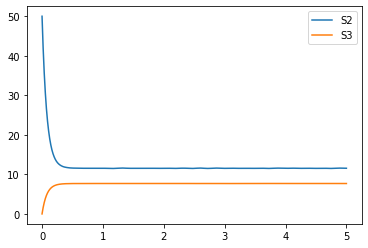

In [24]:
param_dct = {"k": 5, "ref": REF}
result = control.input_output_response(closed_loop, T=TIMES, params=param_dct)
plt.plot(TIMES, result.outputs[0], TIMES, result.outputs[1])
plt.legend(["S2", "S3"])

In [10]:
result.outputs[1][-2:]

array([7.68988725, 7.68994905])

In [20]:
type(control.feedback(controller, sys))

control.iosys.InterconnectedSystem

The output is biased! We wanted $S_3$ to be 10, but it's 7.6.

# Analyzing the Cause of Bias

Using direct calculation, I have calculated the transfer function $G(s) = \frac{k_2}{s + k_3}$.

In [11]:
numerator = CONSTANT_DCT["k2"]
denominator = [1, CONSTANT_DCT["k3"]]
tf = control.TransferFunction(numerator, denominator)
tf

TransferFunction(array([2]), array([1, 3]))

In [12]:
G = 2/(s + 3)
G

2/(s + 3)

In [13]:
C = sympy.symbols("k")

We calculate the transfer function for the closed loop system, $H(s) = \frac{Y(s)}{R(s)}$.

# Constructing Transfer Functions

In [30]:
G = control.TransferFunction([2], [1, 3])
G

TransferFunction(array([2]), array([1, 3]))

In [31]:
k = 5
C = control.TransferFunction([k], [1])

In [32]:
L = control.series(C, G)
L

TransferFunction(array([10.]), array([1, 3]))

In [33]:
H = control.feedback(L)
H

TransferFunction(array([10.]), array([ 1., 13.]))

In [34]:
H.dcgain()

0.7692307692307693

In [35]:
H.pole()

array([-13.])

We moved the pole of the original system from -3 to -13.

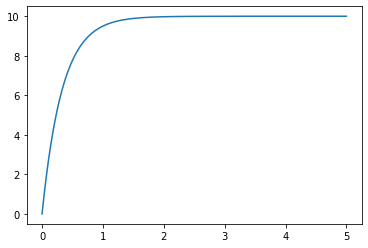

In [44]:
result = control.forced_response(G, T=TIMES, U=15)
result.outputs
plt.plot(TIMES, result.outputs)

# Infrastructure for Studying Feedback Design

We want a function that takes as input
* $k$: the parameter of the controller
* $G$: the transfer function of the system
We will output the transfer function of the closed loop system.